In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Import dependencies**

In [ ]:
# Main
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For naive bayes
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
df_raw = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["sentiment", "time", "date", "query", "username", "tweet"]

# Show the first 10 rows of the dataframe.
df_raw.head()

,sentiment,time,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['sentiment', 'tweet']]

# Replacing the label 4 with 1.
df['sentiment'] = df['sentiment'].replace(4,1)

df.head(10)

<ipython-input-4-5519a0907b82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace(4,1)


,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


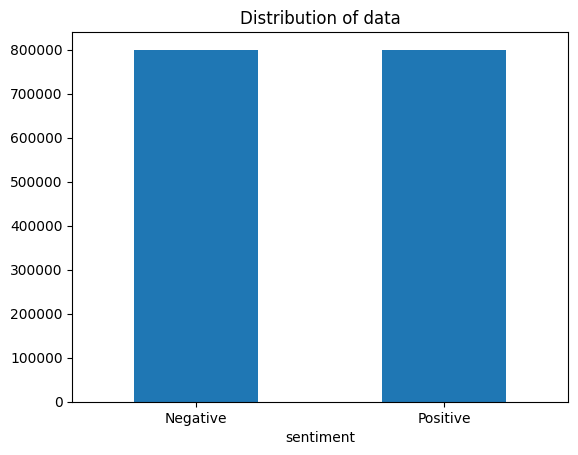

In [ ]:
# Checking the data's output balance
# Label '4' denotes positive sentiment and '0' denotes negative sentiment
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

No trimming done


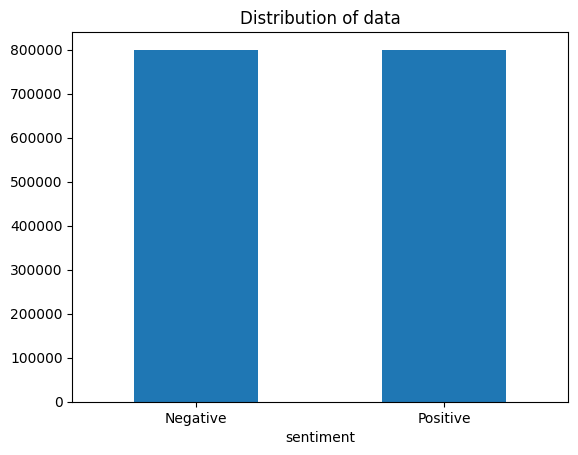

In [ ]:
trim_df = False # If you set this to true -> trim dataframe to 1/80 for efficiency

is_trimmed = False # This should always be initialized to false. Will be set to true if trimming occurs

if trim_df:
    print("Trimming the dataset to 1/80")
    print("Nr rows before trim:", len(df))
    df_pos = df[df['sentiment'] == 1]
    df_neg = df[df['sentiment'] == 0]
    df_pos = df_pos.iloc[:int(len(df_pos)/80)]
    df_neg = df_neg.iloc[:int(len(df_neg)/80)]
    df = pd.concat([df_pos, df_neg])
    trim_df = False # prevent running more than once
    is_trimmed = True
    print("Nr rows after trim:", len(df))
else:
    print("No trimming done")

# Checking the data's output balance
# Label '4' denotes positive sentiment and '0' denotes negative sentiment
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
df['processed_tweet'] = df.tweet.apply(preprocess_apply)

CPU times: user 1min 38s, sys: 556 ms, total: 1min 38s
Wall time: 1min 44s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **Analyze the data**

In [ ]:
df.head()

,sentiment,tweet,processed_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",<user> <url> aww thatis a bummer you shou...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",<user> no it is not behaving at all i am mad...


### Analyze most common words

In [ ]:
processedtext = list(df['processed_tweet'])
if is_trimmed:
    data_pos = processedtext[10000:]
    data_neg = processedtext[:10000]
else:
    data_pos = processedtext[800000:]
    data_neg = processedtext[:800000]

### Word cloud of most common positive words

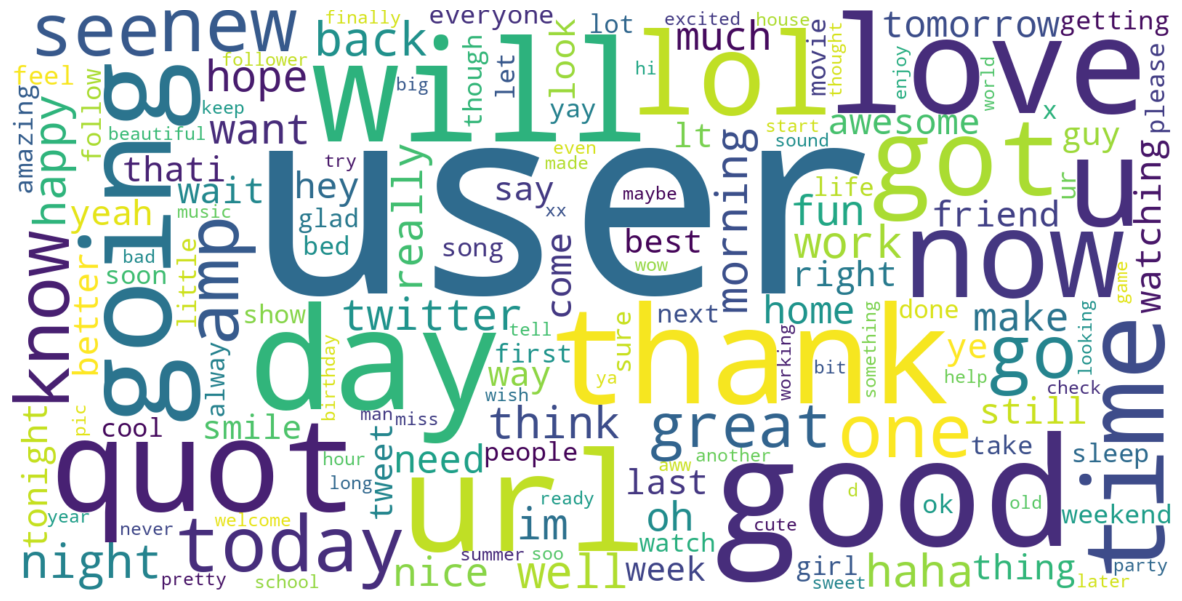

In [ ]:
plt.figure(figsize = (15,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,  background_color ='white', min_font_size = 25,
               collocations=False).generate(" ".join(data_pos))
plt.axis("off")

plt.imshow(wc , interpolation = 'bilinear')

### Word cloud of most common negative words

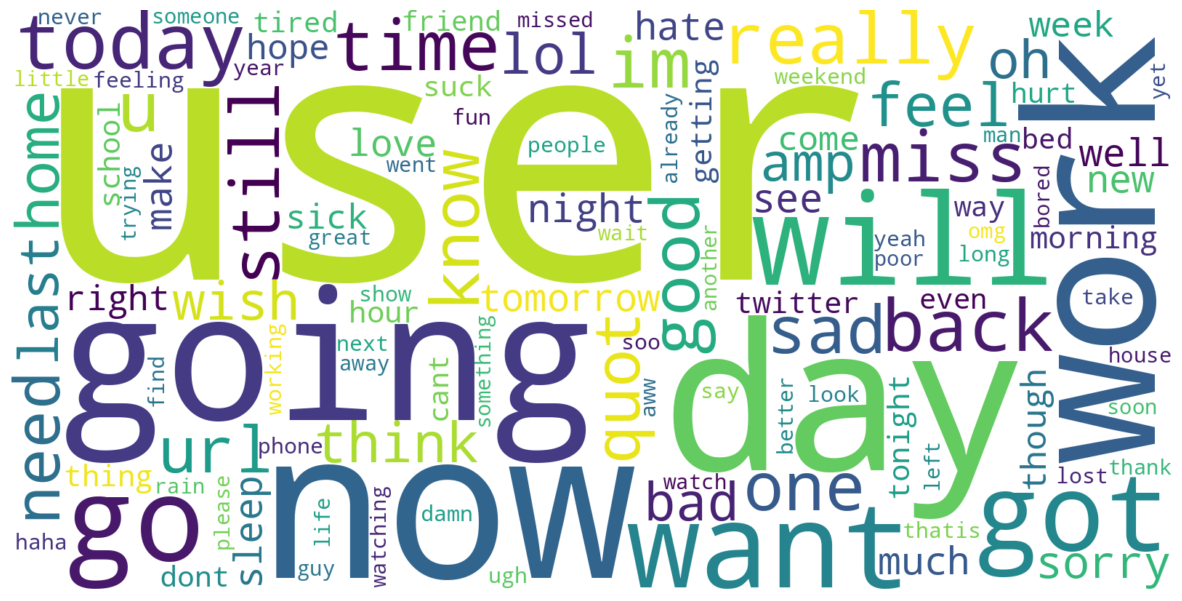

In [ ]:
plt.figure(figsize = (15,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,  background_color ='white', min_font_size = 25,
               collocations=False).generate(" ".join(data_neg))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
from sklearn.model_selection import train_test_split

#X_data, y_data = np.array(df['processed_tweet']), np.array(df['sentiment'])

df_train, df_test = train_test_split(df, test_size=0.05, random_state=42)
X_train, y_train = np.array(df_train['processed_tweet']), np.array(df_train['sentiment'])
X_test, y_test = np.array(df_test['processed_tweet']), np.array(df_test['sentiment'])

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.05, random_state = 42)

print("Nr of samples in each set after split:\n")
print("  TRAIN size:", len(X_train))
print("  TEST size:", len(X_test), "\n")

print('Data Split done.')

pos = 0
neg = 0
for val in y_train:
    if val == 0:
        neg +=1
    else: pos +=1
print("pos", pos, "neg", neg)

Nr of samples in each set after split:

  TRAIN size: 1520000
  TEST size: 80000 

Data Split done.
pos 759999 neg 760001


In [ ]:
from time import time
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

start_time = time()

pipe = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB())])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'vect__binary': [True, False], # If True, all non zero counts are set to 1. This is what how interpreted "set of words"
    'vect__ngram_range': [(1,1), (1,2)], # unigram, unigram + bigram
    'clf__alpha': [1, 0.1]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1) # defaults to 5-fold
search.fit(df_train['processed_tweet'], df_train['sentiment'])
print("Training complete in", time() - start_time, "seconds")
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Training complete in 2294.677564382553 seconds
Best parameter (CV score=0.805):
{'clf__alpha': 1, 'vect__binary': True, 'vect__ngram_range': (1, 2)}


In [ ]:
from sklearn.metrics import classification_report

y_pred_mnb = search.predict(df_test['processed_tweet'])
print(classification_report(df_test['sentiment'], y_pred_mnb,))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     39999
           1       0.82      0.79      0.80     40001

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

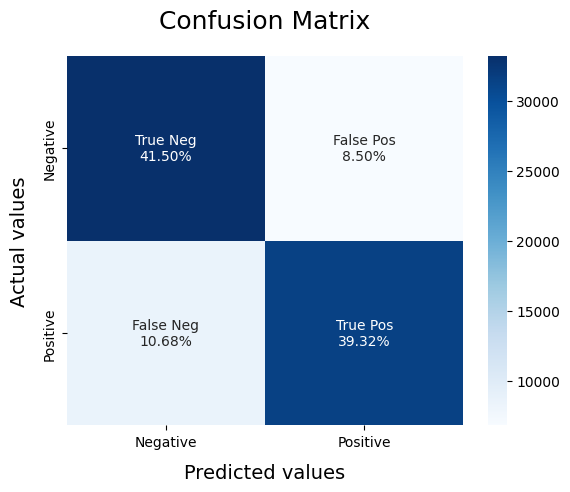

In [ ]:
# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred_mnb, df_test['sentiment'])

In [ ]:
def label_to_str(label):
    if label == 0: return "Negative :"
    return "Positive :"

def nb_predict(df_custom_tweets):
    df_custom_tweets['tweet_processed'] = df_custom_tweets.tweet.apply(preprocess_apply)
    sentiments = search.predict(df_custom_tweets['tweet_processed'])
    for index, row in enumerate(df_custom_tweets['tweet']):
        print(label_to_str(sentiments[index]), row)

In [ ]:
tweet1 = "Lunch at McDonalds today was not tasty"
tweet2 = "I am finally done with my homwork, feeling great"
tweet3 = "Could have been better"

tweet4 = "The song was good!"
tweet5 = "The song was not good!"
tweet6 = "This song was great!"
tweet7 = "This song wasn't great!"

tweet8 = "That's just what I needed today.."
tweet9 = "I love being ignored"
tweet10 = "Just broke my phone, awesome day thus far!"

tweet_list = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6, tweet7, tweet8, tweet9, tweet10]
custom_tweets = pd.DataFrame({'tweet': tweet_list})

nb_predict(custom_tweets)

Negative : Lunch at McDonalds today was not tasty
Positive : I am finally done with my homwork, feeling great
Negative : Could have been better
Positive : The song was good!
Negative : The song was not good!
Positive : This song was great!
Positive : This song wasn't great!
Positive : That's just what I needed today..
Negative : I love being ignored
Negative : Just broke my phone, awesome day thus far!


# Long Short-term memory model

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
